<a href="https://colab.research.google.com/github/psilvaf/ictp-2021-lss-surveys/blob/main/sol_Exercise_1_growth_Pk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: From scratch to $P(k, z)$

In this exercise we will code up the matter power spectrum, and then the amplitude of mass fluctuations sigma8. From scratch!

First, load up the usual functins that we shall need.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad # will need for integration ('quadrature')

###########################################################################
### The block below is entirely optional; it just makes the plots look good
### You can copy it to all ipynb files that you do, or not, up to you
### requires the myplot_style.txt file that you upload as below
### (I will be providing that file)
###########################################################################

'''# figure size and resolution
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

# style file to make plots look nice (large labels etc)
from google.colab import files
src = list(files.upload().values())[0]
open('myplot_style.txt','wb').write(src)

# I will be providing this file - this is optional as I said
plt.style.use('myplot_style.txt')'''

"# figure size and resolution\nplt.rcParams['figure.figsize'] = [9, 6]\nplt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower\n\n# style file to make plots look nice (large labels etc)\nfrom google.colab import files\nsrc = list(files.upload().values())[0]\nopen('myplot_style.txt','wb').write(src)\n\n# I will be providing this file - this is optional as I said\nplt.style.use('myplot_style.txt')"

Then define the base cosmo parameters

In [ ]:
Om=0.3
Ok=0.0
w=-1.0
ns=0.963
A = 2.1e-9 # at k=0.05
H0 = 67.0
Ob=0.022396 *(100/H0)**2 

Then, add the distance functions.

In [ ]:
def dist_integrand(z, Om, Ok, w):
    Ol = 1 - Om - Ok
    return 1.0/np.sqrt(Om*(1+z)**3 + Ol*(1+z)**(3*(1+w)) + Ok*(1+z)**2)

SMALL = 1.0e-5  # some small number, doesn't matter what

# this is really H0 r(z)!
def rz(z, Om, Ok, w):
    chi = quad(dist_integrand, 0, z, args=(Om, Ok, w))[0]
    if (Ok > SMALL):
        return np.sinh(np.sqrt(Ok)*chi) / np.sqrt(Ok) # open
    elif (Ok < -SMALL):
        return np.sin(np.sqrt(-Ok)*chi) / np.sqrt(-Ok) # closed
    else:
        return chi

Now code up the linear growth function. 
The exact equation, valid for all w(z) CDM model is given in the lecture notes. 
However here, you can use an approximate expression from Carroll, Press & Turner (1992) which holds for flat LCDM models:

$g(z)\simeq\displaystyle\frac{5}{2}\,
{\displaystyle\Omega_M(z)\over \Omega_M(z)^{4/7} - \Omega_\Lambda(z) + \left [1+\displaystyle {1\over 2}\Omega_M(z)\right ]\left [1+\displaystyle{1\over 70}\Omega_\Lambda(z)\right ]}$

How do you go from $g(a)$ to $D(a)$? And which one, if either, actually enters $P(k)$??


In [ ]:
# g(a) growth function; assumes flat and LCDM
def ga_LCDM(z, Om):  
    # Omega_M(z)
    Om_z = Om*(1+z)**3 / (Om*(1+z)**3 + (1-Om))
    # Omega_L(z)
    Ol_z = 1.0-Om_z

    numerator   = 2.5 * Om_z 
    denominator = Om_z**(4.0/7) - Ol_z + (1+0.5*Om_z) * (1 + 1.0/70*Ol_z)
    return numerator/denominator

# a*g(a) 
def a_times_ga_LCDM(z, Om):      
    return ga_LCDM(z, Om)/(1+z)

# D(a) = a*g(a)/g(1))
def Da_LCDM(z, Om):
    return a_times_ga_LCDM(z, Om)/ga_LCDM(0, Om)


Code up the transfer function. For simplicity, use the simple BBKS transfer function (Bardeen, Bond, Kaiser, Szalay 1987):

$T(k) = \displaystyle{\ln (1+2.34q)\over 2.34q}
\left [1+3.89q+(16.1q)^2+(5.46q)^3+(6.71q)^4\right ]^{-1/4}$

where

$q \equiv  \displaystyle{1\over \Gamma}{k\over h\,{\rm Mpc}^{-1}};\qquad
\Gamma\equiv \Omega_M h \exp(-\Omega_B - 1.3\Omega_B/\Omega_M)$

In [ ]:
# BBKS transfer function; k needs to be in Mpcinv
def TF_BBKS(k_Mpcinv, h, Om, Ob):    
    Gamma=Om*h*np.exp(-Ob-1.3*Ob/Om) # not original BBKS, but more accurate
    qval = k_Mpcinv/(Gamma*h)
    return np.log(1+2.34*qval)/(2.34*qval)* (1 + 3.89*qval + (16.1*qval)**2 + (5.46*qval)**3 + (6.71*qval)**4)**(-0.25)

Now a big moment - define the linear-theory power spectrum $P(k, z)$.  We gave the formula for the dimensionless version $\Delta^2(k)$ in the lecture notes:

$ \Delta^2(k, a)\equiv \displaystyle{k^3 P(k)\over 2\pi^2}=A\,{4\over 25}
{1\over \Omega_M^2}\left ({k\over k_{\rm piv}}\right )^{n-1}
\left ({k\over H_0}\right )^4 \,
[a g(a)]^2\, T^2(k)$

Everything here is pretty straightforward except the pivot, which is

$k_{\rm piv}=0.05\,{\rm Mpc}^{-1}$.

What's the big deal? The units of this $k$ are $\,{\rm Mpc}^{-1}$, while the units of essentially every other appearance of $k$ in cosmology is the unit we usually want: $h\,{\rm Mpc}^{-1}$. **This creates potential for a bug.** Please take a moment to figure out to get all units to agree.

Define a function for the linear $\Delta^2(k, z)$, and then $P(k, z)$, below.

In [ ]:
# linear dimensionless matter power spectrum, Delta^2(z, k)
def Deltasq_Pk_linear(z, k, A_k005, H0, Om, Ob, ns): # k is in h Mpc^{-1}
    growth =  a_times_ga_LCDM(z, Om)
    h        = H0/100.0
    H0_hMpcinv  = 1.0/2997.9  
    k_Mpcinv = k*h
    k_fid    = 0.05    ## Planck expands around this; in Mpc^{-1}
    transfer = TF_BBKS(k_Mpcinv, h, Om, Ob)
    return 4.0/25 * A_k005 * Om**(-2) * (k_Mpcinv/k_fid)**(ns-1) * (k/H0_hMpcinv)**4 * (growth*transfer)**2


Plot $P(k)$ at $z=0$ and $z=1$. Use range $k\in [0.001, 10]$ in the usual units, and make the plot log-log.

Text(0, 0.5, '$P(k, z)\\,\\, [(h^{-1}\\,{\\rm Mpc})^3]$')

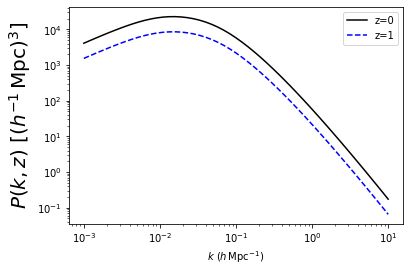

In [ ]:
karr = np.logspace(-3, 1, 51)

z=0
Deltasq_lin      = [Deltasq_Pk_linear  (z, k, A, H0, Om, Ob, ns) for k in karr]
prefac           = [(2*np.pi**2)/k**3 for k in karr]
Pk_lin           = [a*b for a, b in zip(prefac,Deltasq_lin)]

z=1
Deltasq_lin_z1   = [Deltasq_Pk_linear  (z, k, A, H0, Om, Ob, ns) for k in karr]
Pk_lin_z1        = [a*b for a, b in zip(prefac,Deltasq_lin_z1)]

plt.loglog(karr,Pk_lin, 'k', label='z=0')
plt.loglog(karr,Pk_lin_z1, 'b', ls='dashed', label='z=1')

plt.legend(loc="upper right")
plt.xlabel(r'$k\,\, (h\,{\rm Mpc}^{-1})$')
plt.ylabel(r'$P(k, z)\,\, [(h^{-1}\,{\rm Mpc})^3]$', fontsize=20)